In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Resume.csv")
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


**EDA**

In [3]:
df.describe()

,ID
count,2.484000e+03
mean,3.182616e+07
std,2.145735e+07
min,3.547447e+06
25%,1.754430e+07
50%,2.521031e+07
75%,3.611444e+07
max,9.980612e+07


Dataset shape: (2484, 4)

Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']

Missing values:
 ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64


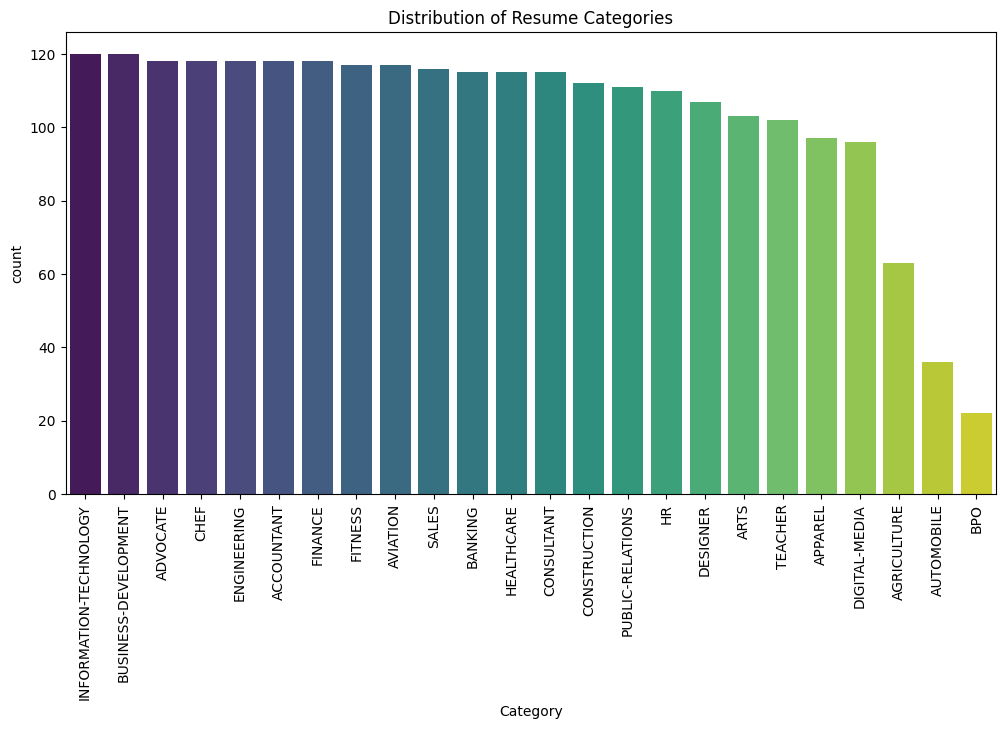

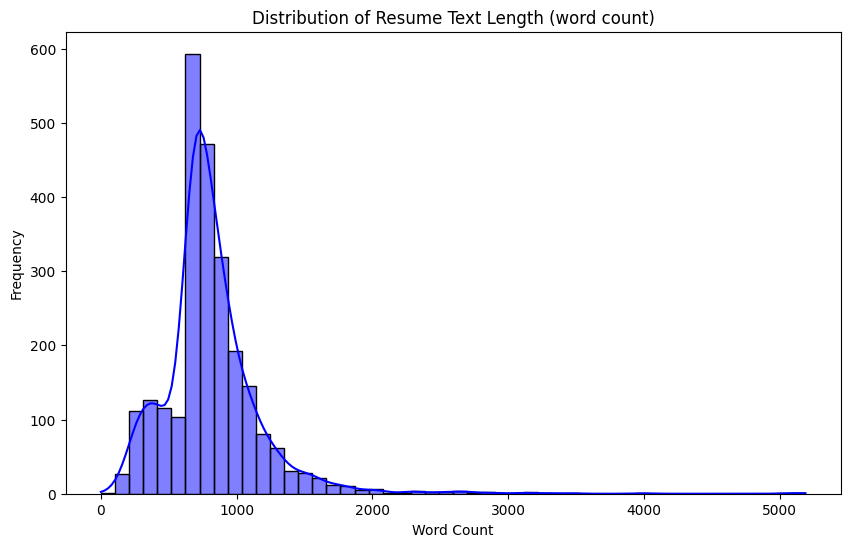

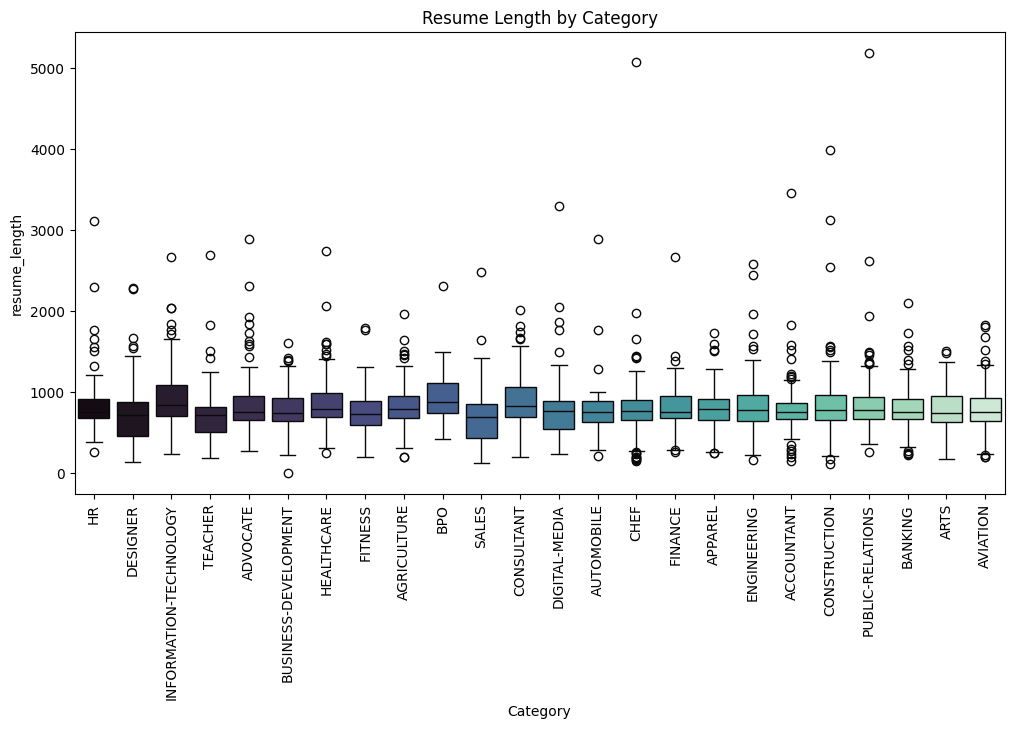

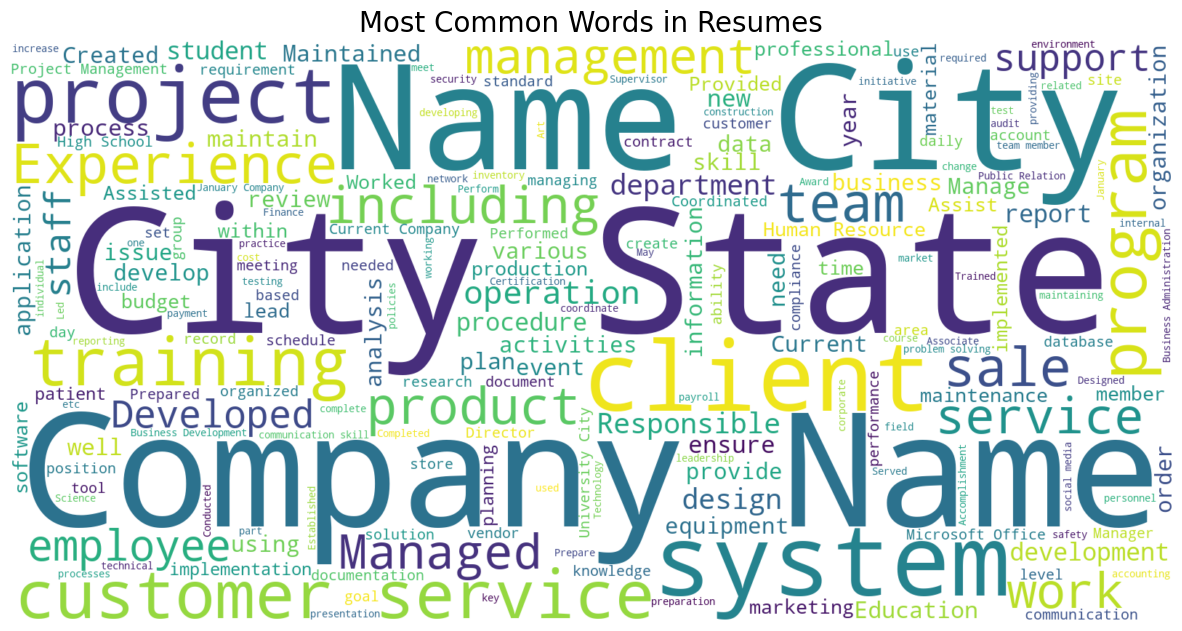

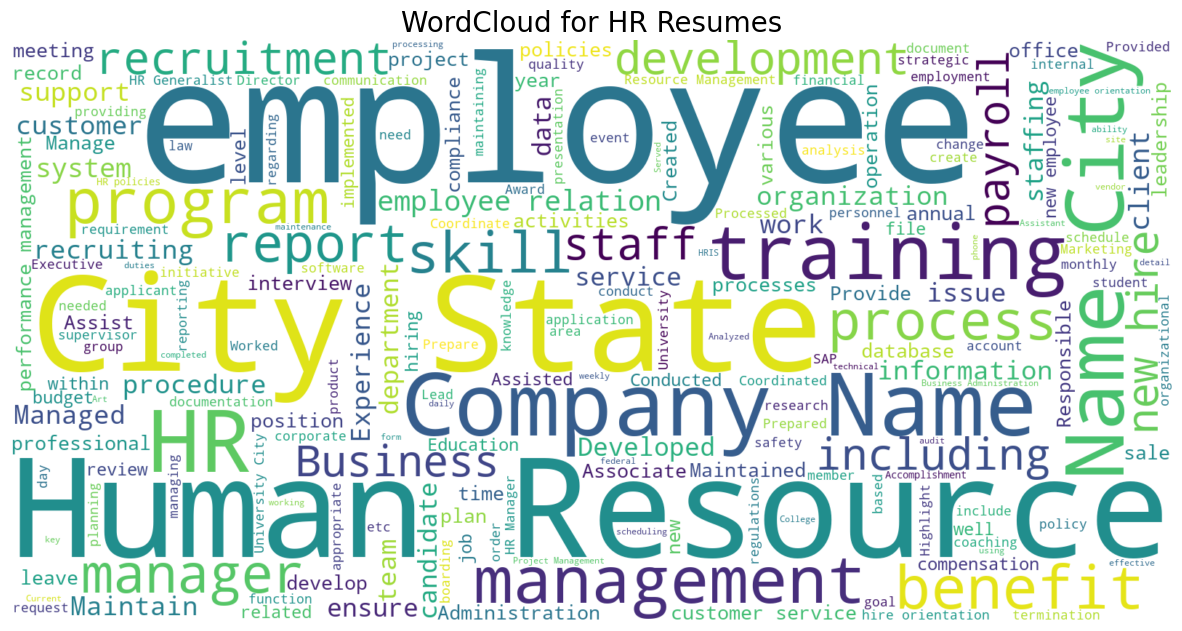

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# -----------------------------
# 1. Basic Info
# -----------------------------
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())

# -----------------------------
# 2. Category Distribution
# -----------------------------
plt.figure(figsize=(12,6))
sns.countplot(x="Category", data=df, order=df['Category'].value_counts().index, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of Resume Categories")
plt.show()

# -----------------------------
# 3. Length of resumes
# -----------------------------
df['resume_length'] = df['Resume_str'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(df['resume_length'], bins=50, kde=True, color="blue")
plt.title("Distribution of Resume Text Length (word count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# -----------------------------
# 4. Average length per Category
# -----------------------------
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='resume_length', data=df, palette="mako")
plt.xticks(rotation=90)
plt.title("Resume Length by Category")
plt.show()

# -----------------------------
# 5. WordCloud for all resumes
# -----------------------------
text = " ".join(resume for resume in df['Resume_str'])
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(text)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Resumes", fontsize=20)
plt.show()

# -----------------------------
# 6. WordCloud per category (example for HR)
# -----------------------------
category = "HR"
text_hr = " ".join(resume for resume in df[df['Category']==category]['Resume_str'])
wordcloud_hr = WordCloud(width=1600, height=800, background_color="white").generate(text_hr)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud_hr, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud for {category} Resumes", fontsize=20)
plt.show()


In [12]:
!pip install wordcloud

In [5]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already done
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_resume(resume_text):
    """
    Cleans a resume string by removing unwanted characters, stopwords, and extra spaces.
    """
    # Remove URLs
    resume_text = re.sub(r'http\S+|www\S+|https\S+', '', resume_text, flags=re.MULTILINE)
    
    # Remove mentions, hashtags, numbers, and special chars
    resume_text = re.sub(r'[^a-zA-Z]', ' ', resume_text)
    
    # Convert to lowercase
    resume_text = resume_text.lower()
    
    # Remove stopwords
    tokens = resume_text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join back to string
    resume_text = ' '.join(tokens)
    
    return resume_text


[nltk_data] Downloading package stopwords to C:\Users\Nandini
[nltk_data]     Shukla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['cleaned_resume'] = df['Resume_str'].apply(lambda x: clean_resume(x))


In [7]:
print("Before Cleaning:\n", df['Resume_str'][0][:500])
print("\nAfter Cleaning:\n", df['cleaned_resume'][0][:500])


Before Cleaning:
          HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-task

After Cleaning:
 hr administrator marketing associate hr administrator summary dedicated customer service manager years experience hospitality customer service management respected builder leader customer focused teams strives instill shared enthusiastic commitment customer service highlights focused customer satisfaction team management marketing savvy conflict resolution techniques training development skilled multi tasker client relations specialist accomplishments missour

*Feature Extraction*

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # you can tune max_features

# Fit & transform on cleaned resumes
X = tfidf.fit_transform(df['cleaned_resume']).toarray()

print("Shape of TF-IDF Matrix:", X.shape)


Shape of TF-IDF Matrix: (2484, 5000)


In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode job categories (e.g., HR, IT, Finance → numbers)
le = LabelEncoder()
y = le.fit_transform(df['Category'])

print("Classes:", le.classes_)


Classes: ['ACCOUNTANT' 'ADVOCATE' 'AGRICULTURE' 'APPAREL' 'ARTS' 'AUTOMOBILE'
 'AVIATION' 'BANKING' 'BPO' 'BUSINESS-DEVELOPMENT' 'CHEF' 'CONSTRUCTION'
 'CONSULTANT' 'DESIGNER' 'DIGITAL-MEDIA' 'ENGINEERING' 'FINANCE' 'FITNESS'
 'HEALTHCARE' 'HR' 'INFORMATION-TECHNOLOGY' 'PUBLIC-RELATIONS' 'SALES'
 'TEACHER']


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predictions
y_pred = nb.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.5513078470824949

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.51      0.88      0.65        24
              ADVOCATE       0.32      0.42      0.36        24
           AGRICULTURE       1.00      0.08      0.14        13
               APPAREL       1.00      0.11      0.19        19
                  ARTS       0.75      0.14      0.24        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.82      0.58      0.68        24
               BANKING       0.87      0.57      0.68        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.36      0.83      0.50        24
                  CHEF       0.81      0.71      0.76        24
          CONSTRUCTION       0.64      0.73      0.68        22
            CONSULTANT       1.00      0.09      0.16        23
              DESIGNER       0.80      0.57      

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],      # Regularization strength
    'max_iter': [1000, 2000, 5000] # Iterations
}

# Initialize model
svm = LinearSVC()

# GridSearchCV
grid = GridSearchCV(
    svm,
    param_grid,
    cv=3,          # 3-fold cross validation
    n_jobs=-1,     # use all CPU cores
    verbose=2,
    scoring='accuracy'
)

# Fit on training data
grid.fit(X_train, y_train)

print("✅ Best Parameters:", grid.best_params_)
print("✅ Best Cross-Validation Score:", grid.best_score_)

# Evaluate on test set
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best Parameters: {'C': 1, 'max_iter': 1000}
✅ Best Cross-Validation Score: 0.6733719748647774
Test Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.63      0.71      0.67        24
           2       1.00      0.62      0.76        13
           3       0.60      0.32      0.41        19
           4       0.53      0.38      0.44        21
           5       1.00      0.43      0.60         7
           6       0.82      0.75      0.78        24
           7       0.78      0.78      0.78        23
           8       0.00      0.00      0.00         4
           9       0.56      0.79      0.66        24
          10       0.82      0.75      0.78        24
          11       0.79      0.86      0.83        22
          12       0.62      0.35      0.44        23
          13       0.90      0.90      0.90        2

In [17]:
import joblib

# Save TF-IDF vectorizer and model
joblib.dump(vectorizer, "resume_vectorizer.pkl")
joblib.dump(best_svm, "resume_svm_model.pkl")


['resume_svm_model.pkl']

In [21]:
from sklearn.svm import SVC
resume_texts = df["Resume_str"].values
y = df["Category"].values

# 3. TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=30000, ngram_range=(1,2))
X = vectorizer.fit_transform(resume_texts)

# 4. Train SVM model
model = SVC(C=10, kernel="linear", probability=True)
model.fit(X, y)

# 5. Save both fitted vectorizer and trained model
joblib.dump(vectorizer, "resume_vectorizer.pkl")
joblib.dump(model, "resume_svm_model.pkl")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


In [1]:
import re

def extract_skills(text):
    skills = ["python", "java", "sql", "c++", "machine learning", "deep learning", "excel", "aws"]
    found = [s for s in skills if s.lower() in text.lower()]
    return list(set(found))

def extract_education(text):
    education_keywords = ["bachelor", "master", "btech", "mtech", "phd", "mba", "b.sc", "m.sc"]
    matches = [edu for edu in education_keywords if re.search(edu, text.lower())]
    return matches

def extract_experience(text):
    exp_match = re.findall(r'(\d+)\+?\s*(years|year)', text.lower())
    return exp_match if exp_match else ["Not Mentioned"]


In [2]:
def classify_resume(resume_text, job_role, model, vectorizer):
    X = vectorizer.transform([resume_text])
    predicted_role = model.predict(X)[0]
    return predicted_role, "Good Fit" if predicted_role.lower() == job_role.lower() else "Not Fit"


In [3]:
!pip install psycopg2-binary


   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.6 MB 876.4 kB/s eta 0:00:03
   -------- ------------------------------- 0.5/2.6 MB 876.4 kB/s eta 0:00:03
   ------------ --------------------------- 0.8/2.6 MB 902.9 kB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.6 MB 934.4 kB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.6 MB 1.0 MB/s eta 0:00:02
   ------------------------ --------------- 1.6/2.6 MB 1.1 MB/s eta 0:00:01
   ---------------------------- ----------- 1.8/2.6 MB 1.1 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 2.4/2.6 MB 1.1 MB/s eta 0:00:01
   -----------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import psycopg2

def insert_into_db(resume_text, skills, education, experience, predicted_role, fit_status):
    conn = psycopg2.connect(
        host="localhost",
        database="resume_db",
        user="postgres",
        password="riya,123"
    )
    cur = conn.cursor()

    cur.execute("""
        INSERT INTO resumes (resume_text, skills, education, experience, predicted_role, fit_status)
        VALUES (%s, %s, %s, %s, %s, %s)
    """, (resume_text, ','.join(skills), ','.join(education), str(experience), predicted_role, fit_status))

    conn.commit()
    cur.close()
    conn.close()
